## Data Roundup

From request [Run machine learning for new model setups using updated excel sheet](https://trello.com/c/PiYNWrUu)

New Data Sheet.  Control vs All and Park vs Atypical and MSA vs PSP and PSP vs MSA

## Imports and Function Definitions

In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    
    get_metrics(clf.best_estimator_, Xh, yh)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [15]:
param_grid = {
    "classifier__C": np.logspace(-5, 10, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score)
}
_scoring='f1_micro'
_data = pd.read_excel('1002_Data_no_Subj_Site.xlsx')
_random_seed = 55

## 1. Control vs. PD/MSA/PSP

In [16]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=_random_seed)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.6s finished


Best parameters set found on development set:

{'classifier__C': 0.088586679041008323}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.83      0.96      0.89        55
        1.0       0.99      0.92      0.95       146

avg / total       0.94      0.94      0.94       201


recall	0.924657534247
precision	0.985401459854
auc	0.944146948941
specificity	0.963636363636
npv	0.828125
accuracy	0.935323383085


In [17]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.139334011078	0.00522952880066
score_time	0.0259986877441	0.00104540152773
test_recall	0.944632683658	0.0129225120211
train_recall	0.962804222415	0.00518295705752
test_precision	0.983893486355	0.0087585949186
train_precision	0.991544320506	0.00256957708087
test_auc	0.952164826678	0.011504948455
train_auc	0.970749923649	0.0038961200225
test_specificity	0.959696969697	0.0221495598081
train_specificity	0.978695624882	0.00653898971576
test_npv	0.870735053432	0.0254784348043
train_npv	0.910479722975	0.0114338099385
test_accuracy	0.948818313215	0.00993100661661
train_accuracy	0.967229361371	0.00394008264747


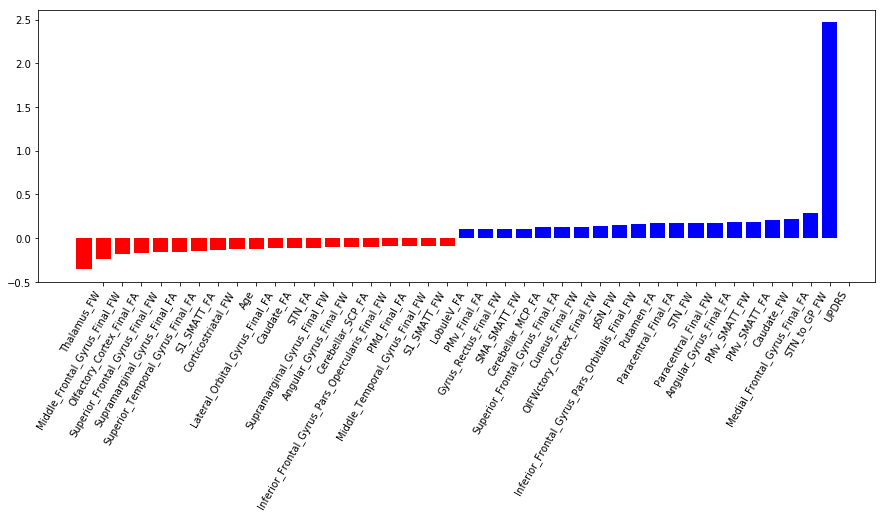

In [18]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	-0.130682251773
Sex	-0.0270564539612
UPDRS	2.46978647903
aSN_FA	-0.0272534149482
Caudate_FA	-0.119249032117
CC2_FA	0.0971422740358
GP_FA	-0.0787320301502
LobuleVI_FA	0.0998943917337
LobuleV_FA	-0.0884594354481
MCP_FA	0.00390229272272
pSN_FA	0.0985640329884
Putamen_FA	0.154717320261
SCP_FA	0.0817276572593
STN_FA	-0.114475508228
Thalamus_FA	0.0936955263024
Vermis_FA	0.0334388416953
RN_FA	-0.00698643934278
PPN_FA	-0.00616586026318
Dentate_FA	-0.0518755931886
CC1_FA	-0.0727512204551
aSN_FW	-0.0512586993487
Caudate_FW	0.20544113546
CC2_FW	-0.0221968781225
GP_FW	-0.0884040790317
LobuleVI_FW	0.0158920658613
LobuleV_FW	-0.0618162869999
MCP_FW	-0.0196527770065
pSN_FW	0.142323473851
Putamen_FW	-0.0476574978057
SCP_FW	0.0906722658978
STN_FW	0.17621562207
Thalamus_FW	-0.357947373471
Vermis_FW	-0.00817330750202
RN_FW	0.00108984231171
PPN_FW	0.0744727094864
Dentate_FW	-0.0831860458928
CC1_FW	0.0691864517768
Angular_Gyrus_Final_FA	0.176923827723
Anterior_Orbital_Gyrus_Final_FA	-0.0240510404816
Ca

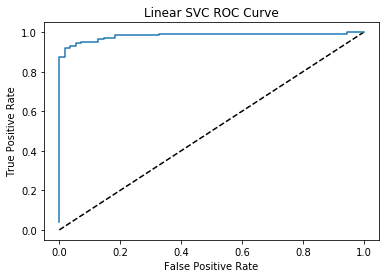

0.0 0.041095890411
0.0 0.876712328767
0.0181818181818 0.876712328767
0.0181818181818 0.917808219178
0.0363636363636 0.917808219178
0.0363636363636 0.931506849315
0.0545454545455 0.931506849315
0.0545454545455 0.945205479452
0.0727272727273 0.945205479452
0.0727272727273 0.952054794521
0.127272727273 0.952054794521
0.127272727273 0.965753424658
0.145454545455 0.965753424658
0.145454545455 0.972602739726
0.181818181818 0.972602739726
0.181818181818 0.986301369863
0.327272727273 0.986301369863
0.327272727273 0.993150684932
0.945454545455 0.993150684932
0.945454545455 1.0
1.0 1.0


In [19]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 2. PD vs MSA/PSP

In [20]:
# Get the data
data2 = group_classes(_data, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=_random_seed)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.6s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.97      0.90      0.94       105
        1.0       0.79      0.93      0.85        40

avg / total       0.92      0.91      0.91       145


recall	0.925
precision	0.787234042553
auc	0.914880952381
specificity	0.904761904762
npv	0.969387755102
accuracy	0.910344827586


In [21]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0788020133972	0.0029052934773
score_time	0.0226005077362	0.002417223437
test_recall	0.792268907563	0.0578073084416
train_recall	0.874298821812	0.0114900804038
test_precision	0.791112313899	0.0569963269966
train_precision	0.879724522761	0.0165496489889
test_auc	0.850590942791	0.0284096292408
train_auc	0.911594805018	0.00513659890986
test_specificity	0.908912978019	0.0286134476964
train_specificity	0.948890788224	0.00816912098629
test_npv	0.911875836999	0.0225622132414
train_npv	0.946597504627	0.00450272505247
test_accuracy	0.873998129141	0.0223368698273
train_accuracy	0.926593662476	0.00498020231121


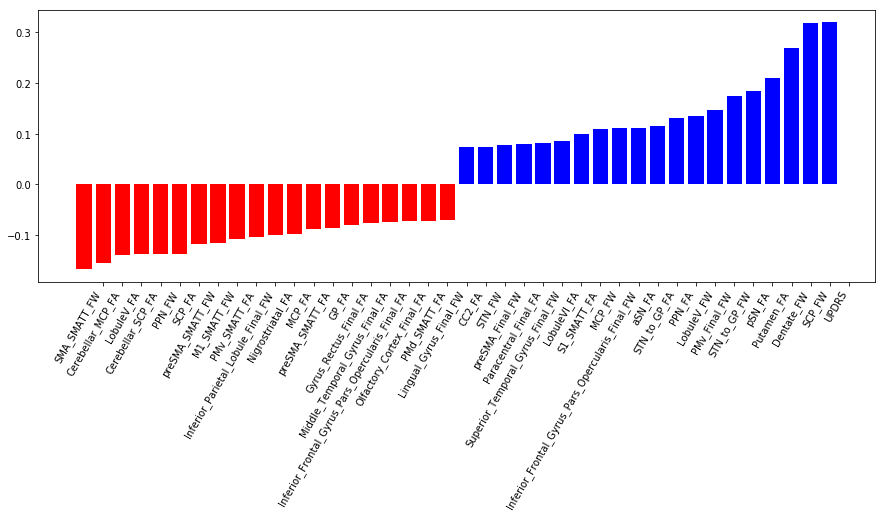

Age	-0.0406126112738
Sex	0.0
UPDRS	0.32018775039
aSN_FA	0.110928369522
Caudate_FA	-0.0445443927948
CC2_FA	0.0731134195356
GP_FA	-0.0859598289437
LobuleVI_FA	0.0858581813149
LobuleV_FA	-0.13985706971
MCP_FA	-0.0976596868706
pSN_FA	0.184044930855
Putamen_FA	0.209030426775
SCP_FA	-0.137373329869
STN_FA	0.0592858737686
Thalamus_FA	-0.0405980946063
Vermis_FA	0.0692183597681
RN_FA	-0.0236590163246
PPN_FA	0.131216495795
Dentate_FA	0.059202767254
CC1_FA	0.00261512272507
aSN_FW	0.037385718773
Caudate_FW	0.0376521766151
CC2_FW	-0.0392794024224
GP_FW	0.0411587294057
LobuleVI_FW	-0.03394727397
LobuleV_FW	0.134991245228
MCP_FW	0.108832862129
pSN_FW	0.0258832491702
Putamen_FW	0.0290785207225
SCP_FW	0.318450950478
STN_FW	0.0731293495953
Thalamus_FW	0.0568910874207
Vermis_FW	0.0537895424267
RN_FW	-0.0157329405705
PPN_FW	-0.137395509061
Dentate_FW	0.269609785754
CC1_FW	0.0378641608274
Angular_Gyrus_Final_FA	0.0281778184652
Anterior_Orbital_Gyrus_Final_FA	0.01001307766
Calcarine_Sulcus_Final_FA	-0.03085

In [22]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       0.97      0.90      0.94       105
        1.0       0.79      0.93      0.85        40

avg / total       0.92      0.91      0.91       145



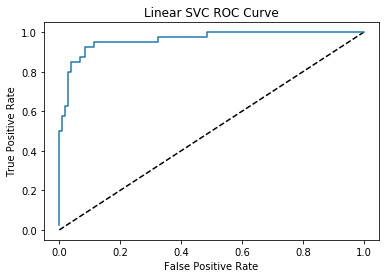

0.0 0.025
0.0 0.5
0.00952380952381 0.5
0.00952380952381 0.575
0.0190476190476 0.575
0.0190476190476 0.625
0.0285714285714 0.625
0.0285714285714 0.8
0.0380952380952 0.8
0.0380952380952 0.85
0.0666666666667 0.85
0.0666666666667 0.875
0.0857142857143 0.875
0.0857142857143 0.925
0.114285714286 0.925
0.114285714286 0.95
0.32380952381 0.95
0.32380952381 0.975
0.485714285714 0.975
0.485714285714 1.0
1.0 1.0


In [23]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 3. MSA (positive) vs PSP

In [24]:
# Get the data
data3 = group_classes(_data, {3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=_random_seed)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    7.5s remaining:    1.2s


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.89      0.83      0.86        30
        1.0       0.67      0.77      0.71        13

avg / total       0.82      0.81      0.82        43


recall	0.769230769231
precision	0.666666666667
auc	0.801282051282
specificity	0.833333333333
npv	0.892857142857
accuracy	0.813953488372


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.6s finished


In [25]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.010200548172	0.000399097700988
score_time	0.00550322532654	0.000775436061339
test_recall	0.900952380952	0.0358125631942
train_recall	0.982330827068	0.0158331734056
test_precision	0.826587301587	0.078020353825
train_precision	0.856753770423	0.0255876012875
test_auc	0.879949874687	0.042844518066
train_auc	0.931782502141	0.0111103714932
test_specificity	0.858947368421	0.0729398492365
train_specificity	0.881234177215	0.0263255383405
test_npv	0.923698830409	0.0264310503776
train_npv	0.986255086072	0.0122710423822
test_accuracy	0.876261777438	0.0473867558021
train_accuracy	0.923495300797	0.0130213489634


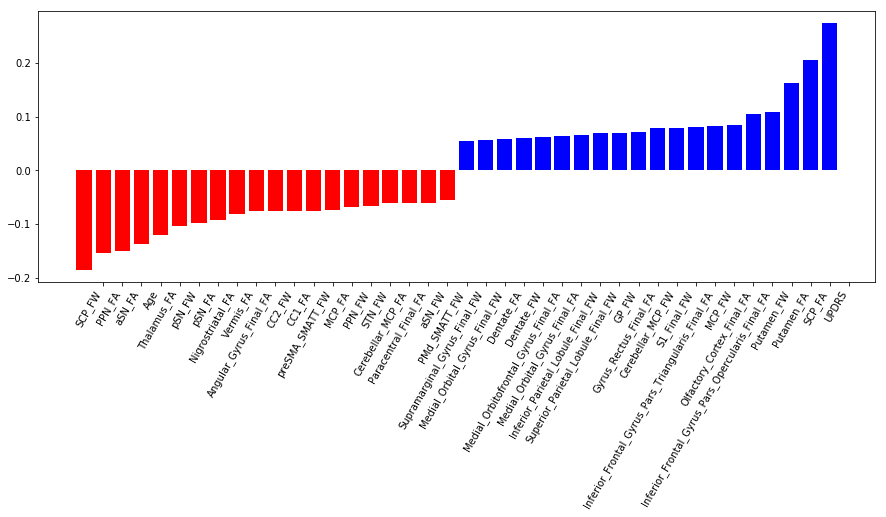

Age	-0.136409040829
Sex	-0.0408684239088
UPDRS	0.275024665333
aSN_FA	-0.149188410171
Caudate_FA	-0.0192993078021
CC2_FA	-0.0246956730561
GP_FA	0.0265136804937
LobuleVI_FA	-0.0381976313152
LobuleV_FA	0.0459978555446
MCP_FA	-0.0742755079312
pSN_FA	-0.0987578471785
Putamen_FA	0.162387844256
SCP_FA	0.205724218313
STN_FA	-0.051307521595
Thalamus_FA	-0.120684730605
Vermis_FA	-0.0809031018927
RN_FA	0.0124111194893
PPN_FA	-0.154205547056
Dentate_FA	0.0591106318817
CC1_FA	-0.0755776173622
aSN_FW	-0.0599536265546
Caudate_FW	-0.0115940011855
CC2_FW	-0.0758295551283
GP_FW	0.0697418831905
LobuleVI_FW	-0.0180495574067
LobuleV_FW	0.0220088302957
MCP_FW	0.0832207237751
pSN_FW	-0.103023628875
Putamen_FW	0.109834222454
SCP_FW	-0.185488485673
STN_FW	-0.0660084277757
Thalamus_FW	-0.0427216064969
Vermis_FW	0.0273440190972
RN_FW	-0.045285295148
PPN_FW	-0.0687590185557
Dentate_FW	0.0601093475301
CC1_FW	-0.0171509994711
Angular_Gyrus_Final_FA	-0.0760822622479
Anterior_Orbital_Gyrus_Final_FA	0.0392220985714
Ca

In [26]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       0.89      0.83      0.86        30
        1.0       0.67      0.77      0.71        13

avg / total       0.82      0.81      0.82        43



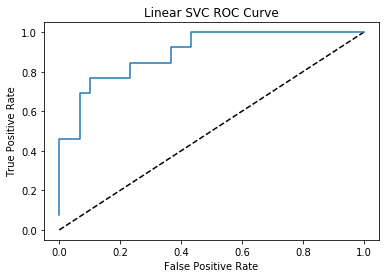

0.0 0.0769230769231
0.0 0.461538461538
0.0666666666667 0.461538461538
0.0666666666667 0.692307692308
0.1 0.692307692308
0.1 0.769230769231
0.233333333333 0.769230769231
0.233333333333 0.846153846154
0.366666666667 0.846153846154
0.366666666667 0.923076923077
0.433333333333 0.923076923077
0.433333333333 1.0
1.0 1.0


In [27]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)

## 4. PSP (positive) vs MSA

In [28]:
# Get the data
data4 = group_classes(_data, {2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    7.5s remaining:    1.2s


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.67      0.77      0.71        13
        1.0       0.89      0.83      0.86        30

avg / total       0.82      0.81      0.82        43


recall	0.833333333333
precision	0.892857142857
auc	0.801282051282
specificity	0.769230769231
npv	0.666666666667
accuracy	0.813953488372


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.6s finished


In [29]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.010403585434	0.000794800256995
score_time	0.00560545921326	0.00120228199054
test_recall	0.858947368421	0.0729398492365
train_recall	0.881234177215	0.0263255383405
test_precision	0.923698830409	0.0264310503776
train_precision	0.986255086072	0.0122710423822
test_auc	0.879949874687	0.042844518066
train_auc	0.931782502141	0.0111103714932
test_specificity	0.900952380952	0.0358125631942
train_specificity	0.982330827068	0.0158331734056
test_npv	0.826587301587	0.078020353825
train_npv	0.856753770423	0.0255876012875
test_accuracy	0.876261777438	0.0473867558021
train_accuracy	0.923495300797	0.0130213489634


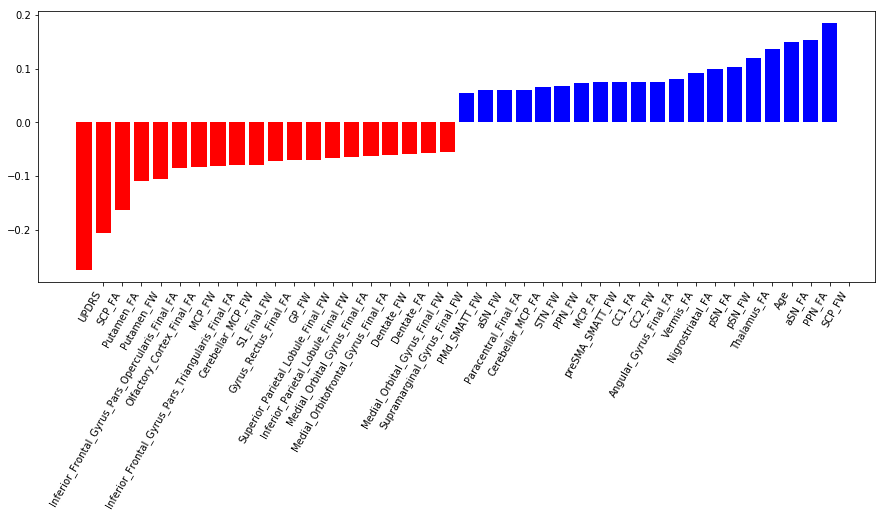

Age	0.136385091108
Sex	0.0408123164569
UPDRS	-0.274976658545
aSN_FA	0.149135031144
Caudate_FA	0.0193797749595
CC2_FA	0.0248632210564
GP_FA	-0.0264047804513
LobuleVI_FA	0.0382352213832
LobuleV_FA	-0.0458763629965
MCP_FA	0.0743042979131
pSN_FA	0.0987483199736
Putamen_FA	-0.162424527963
SCP_FA	-0.205717807841
STN_FA	0.051329541284
Thalamus_FA	0.120659934842
Vermis_FA	0.0807117121331
RN_FA	-0.0123614406316
PPN_FA	0.154129234307
Dentate_FA	-0.0591345261233
CC1_FA	0.0754134224956
aSN_FW	0.0600026486026
Caudate_FW	0.0116718481648
CC2_FW	0.0757994586719
GP_FW	-0.0697233298565
LobuleVI_FW	0.0180492676601
LobuleV_FW	-0.0221203395051
MCP_FW	-0.0831810525834
pSN_FW	0.103091874529
Putamen_FW	-0.109811747783
SCP_FW	0.18549290771
STN_FW	0.0660217555143
Thalamus_FW	0.0426365099806
Vermis_FW	-0.0272819392868
RN_FW	0.0451764130632
PPN_FW	0.0688197872224
Dentate_FW	-0.0601393450813
CC1_FW	0.0171111268717
Angular_Gyrus_Final_FA	0.0759778822611
Anterior_Orbital_Gyrus_Final_FA	-0.0391670044483
Calcarine_Sul

In [30]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       0.67      0.77      0.71        13
        1.0       0.89      0.83      0.86        30

avg / total       0.82      0.81      0.82        43



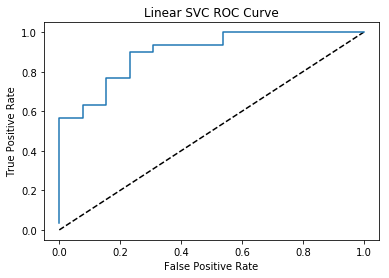

0.0 0.0333333333333
0.0 0.566666666667
0.0769230769231 0.566666666667
0.0769230769231 0.633333333333
0.153846153846 0.633333333333
0.153846153846 0.766666666667
0.230769230769 0.766666666667
0.230769230769 0.9
0.307692307692 0.9
0.307692307692 0.933333333333
0.538461538462 0.933333333333
0.538461538462 1.0
1.0 1.0


In [31]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)